参考引用  
https://www.kaggle.com/code/fangya/ubiquant-investment-mini-eda-lgbm-linreg

target：投資収益率

# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm
from sklearn.model_selection import StratifiedKFold 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Color Scheme

In [4]:
sns.color_palette("mako_r",10)

[(0.68051833, 0.88963189, 0.75150483),
 (0.4285828, 0.82635051, 0.6780564),
 (0.26604085, 0.73564353, 0.67914062),
 (0.20968223, 0.63088252, 0.6701105),
 (0.20418396, 0.53013715, 0.64946117),
 (0.21112526, 0.42903064, 0.6266318),
 (0.23807973, 0.32226344, 0.58941872),
 (0.25007383, 0.22365053, 0.45519562),
 (0.20976258, 0.14925954, 0.29687795),
 (0.13701138, 0.08259683, 0.15060265)]

# Read in the data by parquet

In [6]:
! ls ../

01.ump-create-pickle-dataset.ipynb		  EDA
02.CombinatorialPurgedGroupKFold_tf_record.ipynb  model


In [8]:
train = pd.read_pickle('../../data/input/ubiquant-market-prediction-half-precision-pickle/train.pkl') 
train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


# Histgram

In [9]:
def histg(data, color , label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    data.plot.hist(bins=60, color=color)
    plt.title(label)
    plt.show()

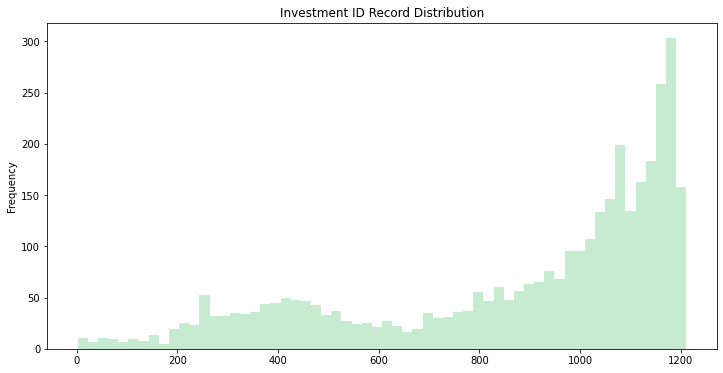

In [10]:
obs_by_asset = train.groupby(['investment_id'])['target'].count()
histg(obs_by_asset,"#c6ebd1", "Investment ID Record Distribution")

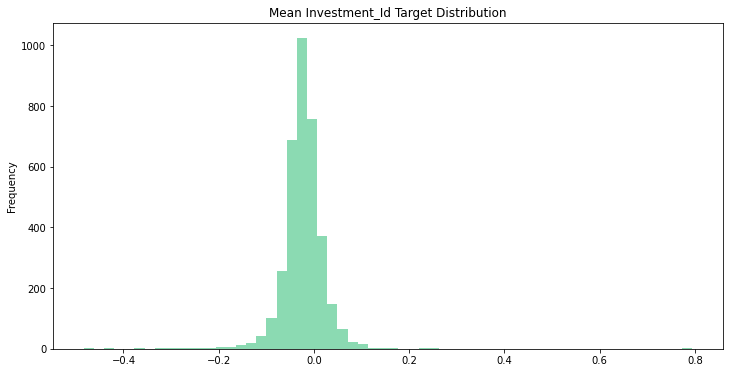

In [13]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)
histg(mean_target,"#8bdab2", "Mean Investment_Id Target Distribution")

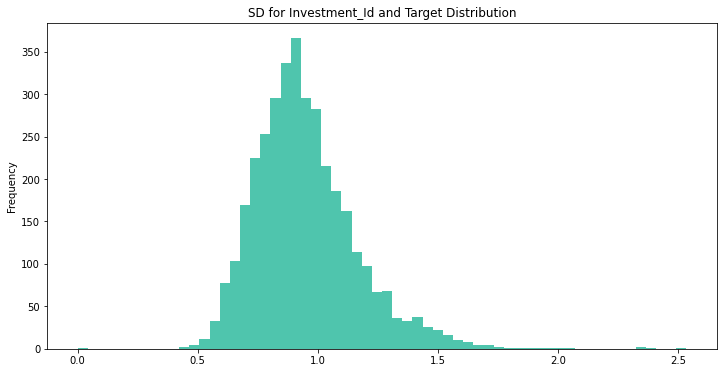

In [14]:
sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)
histg(sts_target,"#4fc5ad", "SD for Investment_Id and Target Distribution")

Text(0.5, 1.05, 'Target Histogram of Different Investment ID')

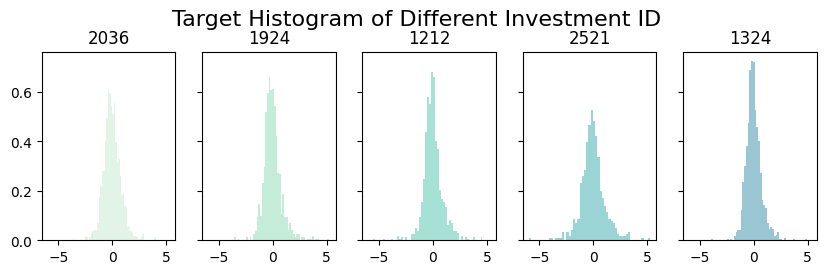

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
#colors = ['tab:green', 'tab:blue', 'tab:pink', 'tab:red', 'tab:purple']
colors = ["#c6ebd1","#8bdab2","#4fc5ad","#38aaac","#348fa7"]
for i, (ax, investment_id) in enumerate(zip(axes.flatten(), np.random.choice(train["investment_id"].unique(),5))):
    x = train.loc[train.investment_id==investment_id, "target"]
    ax.hist(x, alpha=0.5, bins=55, density=True, stacked=True, label=str(investment_id), color=colors[i])
    ax.set_title(investment_id)
plt.suptitle('Target Histogram of Different Investment ID', y=1.05, size=16) 

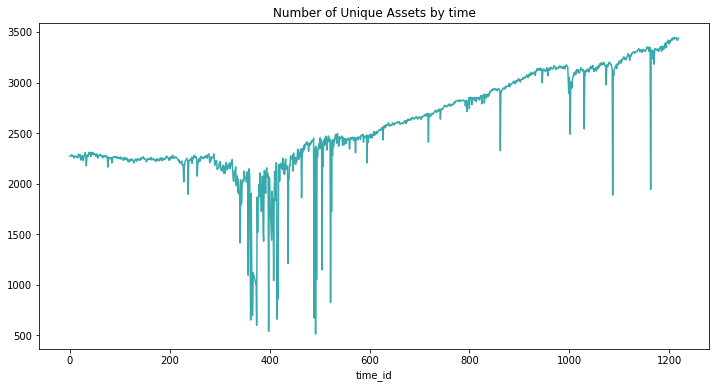

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
train.groupby('time_id')['investment_id'].nunique().plot(color="#38aaac")
plt.title("Number of Unique Assets by time")
plt.show()

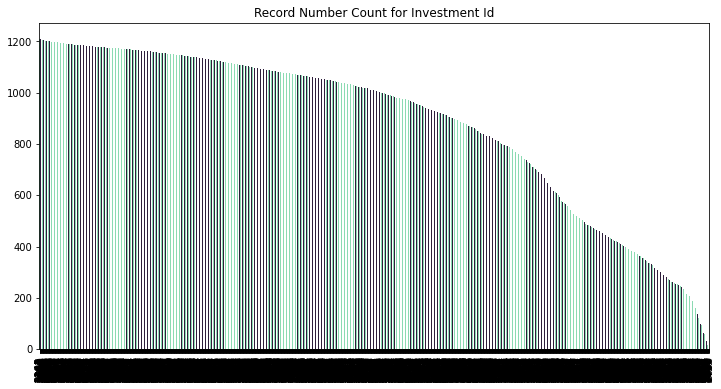

In [17]:
train['investment_id'].value_counts().plot(kind = 'bar',figsize = (12,6), color=("#8bdab2","#2e1e3b"))
plt.title("Record Number Count for Investment Id")
plt.show()

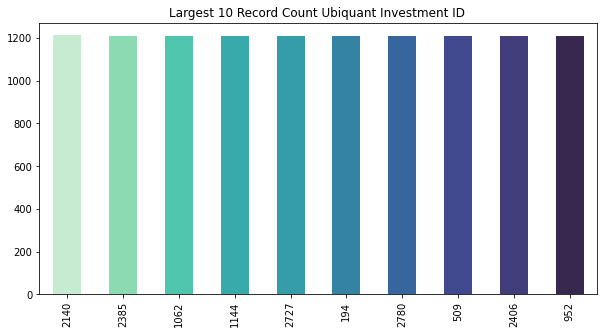

In [18]:
train['investment_id'].value_counts().nlargest(10).plot(kind = 'bar',figsize = (10,5), 
                        color=("#c6ebd1","#8bdab2","#4fc5ad", "#38aaac","#359caa","#3482a4",
                            "#37659e","#40498e","#413d7b","#37284f","#241628"))
plt.title("Largest 10 Record Count Ubiquant Investment ID ")
plt.show()

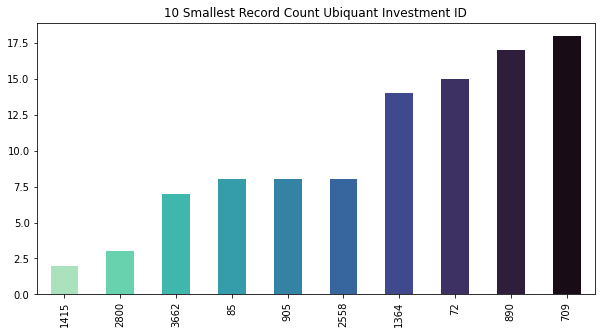

In [19]:
train['investment_id'].value_counts().nsmallest(10).plot(kind = 'bar',figsize = (10,5), 
                        color=("#abe2be","#68d1ad", "#40b7ad", "#359caa","#3482a4",
                             "#37659e","#40498e","#3d3164","#2e1e3b","#180d16"))
plt.title(" 10 Smallest Record Count Ubiquant Investment ID ")
plt.show()

# Investment ID for Target Value and Time-Id

データ数の多いinvestment IDは高いボラティリティ(=一般的に価格変動の度合いを示す言葉で、「ボラティリティーが大きい」という場合は、その商品の価格変動が大きいことを意味する)を持っており、アビトラージ（=「裁定取引」金利差や価格差に注目して、割安な投資対象を買い、割高な投資対象を売るポジションを取ることで、両者のサヤを抜こうとする手法。）を作りやすく利益につながる。  
一方で、investment ID=1415はデータ数が少なく、投資による期待値が低い。

In [20]:
array=[2140,2385,1062,1144,2727,194,2780,509,2406,952,1415,2800,3662,85,905]
s_id=train.loc[train['investment_id'].isin(array)]

In [21]:
def data_id(id1):
    df=s_id[s_id["investment_id"]==id1].set_index("time_id")
    return df

id1=data_id(2140)
id2=data_id(2385)
id3=data_id(1062)
id4=data_id(1144)
id5=data_id(2727)
id6=data_id(1415)
id7=data_id(2800)
id8=data_id(3662)
id9=data_id(85)
id10=data_id(905)

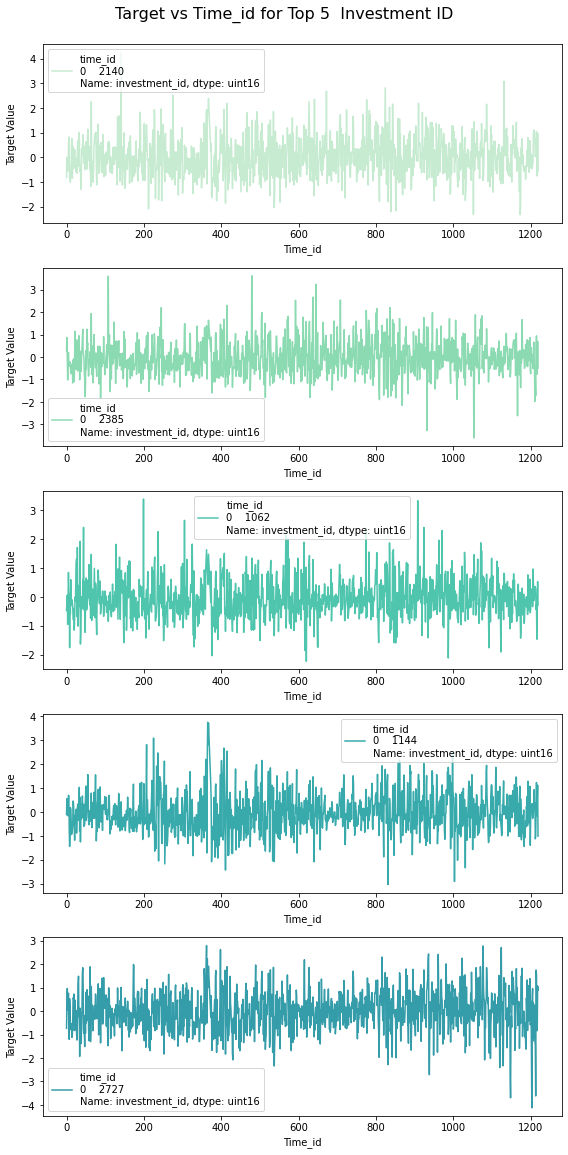

In [22]:
# Plot the target value for top investment id
f= plt.figure(figsize=(8,16))  

def gplot(no, data, color):
    ax=f.add_subplot(no)
    plt.plot(data["target"], label=data["investment_id"].head(1), color=color)
    plt.legend()
    plt.xlabel("Time_id")
    plt.ylabel("Target Value")
    return plt

gplot(no=511, data=id1, color="#c6ebd1")
gplot(no=512, data=id2, color="#8bdab2")
gplot(no=513, data=id3, color="#4fc5ad")
gplot(no=514, data=id4, color="#38aaac")
gplot(no=515, data=id5, color="#359caa")
plt.suptitle('Target vs Time_id for Top 5  Investment ID', y=1, size=16) 
plt.tight_layout()
plt.show()

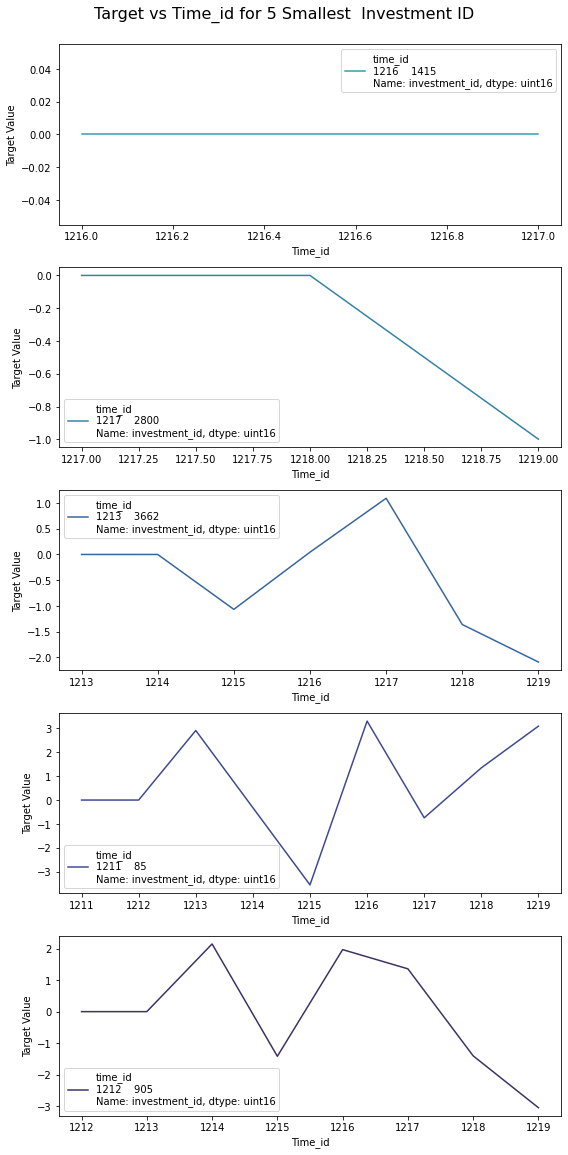

In [23]:
# Plot the target value for smallest investment id
f= plt.figure(figsize=(8,16))  

def gplot(no, data, color):
    ax=f.add_subplot(no)
    plt.plot(data["target"], label=data["investment_id"].head(1), color=color)
    plt.legend()
    plt.xlabel("Time_id")
    plt.ylabel("Target Value")
    return plt

gplot(no=511, data=id6, color="#359caa")
gplot(no=512, data=id7, color="#3482a4")
gplot(no=513, data=id8, color="#37659e")
gplot(no=514, data=id9, color="#40498e")
gplot(no=515, data=id10, color="#3d3164")
plt.suptitle('Target vs Time_id for 5 Smallest  Investment ID', y=1, size=16) 
plt.tight_layout()
plt.show()

# Mini Correlation Plot

In [24]:
data_types_dict = {
    'time_id': 'int32',
    'investment_id': 'int16',
    "target": 'float16',
}

features = [f'f_{i}' for i in range(300)]

for f in features:
    data_types_dict[f] = 'float16'
    
target = 'target'

/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


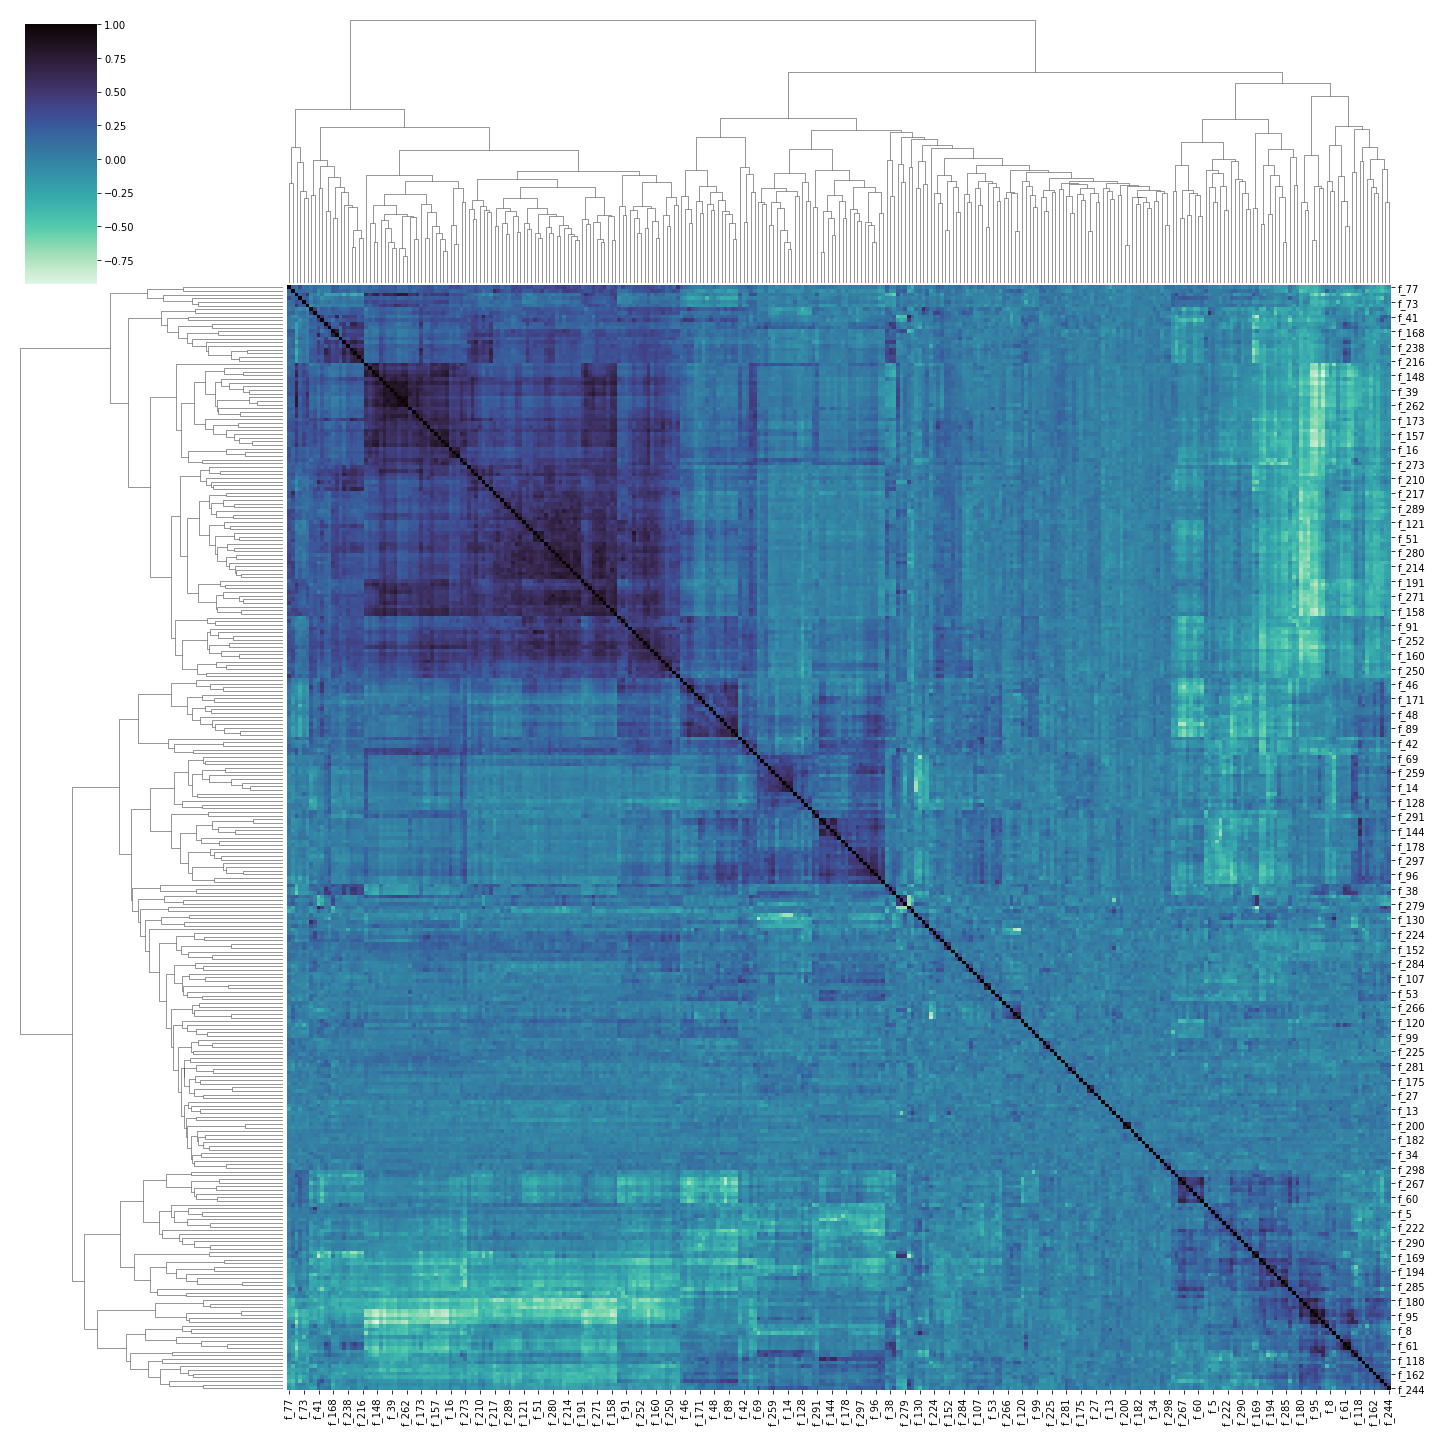

In [25]:
sample_corr=train.sample(frac=0.0001, random_state=18)
correlation = sample_corr[[target] + features].corr()
sns.clustermap(correlation, figsize=(20, 20), cmap="mako_r")

# 3. Mini Ubiquant Feautrue Selection

In [26]:
#seed
s_train=train.sample(frac=0.01, random_state=8)

In [27]:
s_train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
2566567,1667,1043,-2.869141,0.181030,0.732422,-0.596680,-0.210815,0.642578,0.350342,-1.506836,...,-0.267578,-0.581543,-0.154663,-0.857910,-0.634766,0.890625,-0.806641,0.373535,-0.534180,0.257324
2884377,79,1143,0.604980,-0.170532,2.523438,-0.277100,-0.233887,0.965332,1.171875,-1.061523,...,0.984863,0.427246,0.189087,0.858887,-0.593750,-1.276367,-0.369873,1.112305,-0.550781,-0.265137
1209567,707,563,-2.542969,-1.204102,0.066223,-0.640625,-0.406006,-1.186523,-0.212036,1.014648,...,2.919922,-1.010742,0.365479,2.849609,-0.568848,-2.783203,3.710938,0.796875,-0.683105,-0.768066
1470297,3388,666,0.778809,-0.992676,2.460938,-0.163086,-0.618652,0.241455,-0.511230,1.125000,...,-0.491699,-0.606934,0.102844,-1.407227,-0.782227,-0.281738,1.640625,-0.060791,-0.710938,-0.338623
3053938,1620,1194,-0.045624,-1.414062,-1.806641,0.755371,0.199463,0.237915,-0.491943,1.504883,...,1.475586,-0.666016,-0.959473,1.573242,0.263672,1.965820,1.732422,-1.721680,0.391846,-1.635742


In [28]:

obs_by_asset = s_train.groupby(['investment_id'])['target'].count().to_dict()
target = s_train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
features = s_train.columns[4:]

del(obs_by_asset)

In [29]:
# investment_idの出現回数とtargetの相関係数を算出

print(np.corrcoef(target,s_train['target'])[0][1])

0.0063371809334173


相関関係ほぼなしだが。。

In [30]:
# investment_idの出現回数と各種特徴量の相関係数を算出

corrs = list()
for col in features:
    corr = np.corrcoef(target, s_train[col])[0][1]
    corrs.append(corr)
    
del(target)

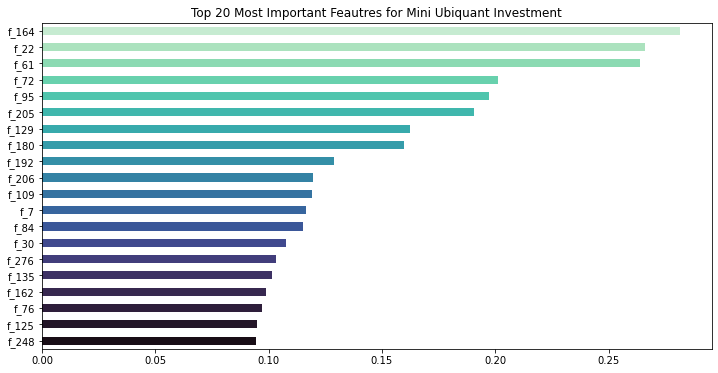

In [31]:
feat_importances = pd.Series(corrs, index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=("#c6ebd1","#abe2be","#8bdab2","#68d1ad","#4fc5ad",
                                          "#40b7ad","#38aaac","#359caa","#348fa7","#3482a4",
                                           "#3573a1","#37659e","#3b5799","#40498e","#413d7b",
                                         "#3d3164","#37284f","#2e1e3b","#241628","#180d16")).invert_yaxis()
plt.title("Top 20 Most Important Feautres for Mini Ubiquant Investment")
plt.show()